In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model, Model
from keras.layers import LSTM, Dense, Input
from keras.optimizers import Adam
import keras.backend as K

In [65]:
def get_csvs_from_dir(directory):
    try:
        datasets_dir = os.path.join(directory, 'environment', 'datasets')
        csv_files = [os.path.join(datasets_dir, file) for file in os.listdir(datasets_dir) if file.endswith('.csv')]
        stock_names = [file.split("\\")[-1].split(".")[0] for file in csv_files]
        return csv_files, stock_names
    except FileNotFoundError:
        print(f"The directory {datasets_dir} does not exist.")
        return [], []

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['datetime'] = pd.to_datetime(df['date'])
    df.set_index('datetime', inplace=True)
    df = df['close'].resample('D').mean()
    df.interpolate(method='linear', inplace=True)
    return df

def build_model(input_shape):
    K.clear_session()
    input_layer = Input(shape=(input_shape[1], input_shape[2]))
    lstm_layer = LSTM(50, activation='relu')(input_layer)
    output_layer = Dense(1)(lstm_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(), loss='mse')
    return model

def process_stock_data(data, start_date, end_date):
    data_filtered = data[start_date:end_date]
    sc = MinMaxScaler(feature_range=(0, 1))
    data_scaled = sc.fit_transform(data_filtered.values.reshape(-1, 1))
    X, y = [], []
    for i in range(10, len(data_scaled)):  # Window size is 10
        X.append(data_scaled[i-10:i, 0])
        y.append(data_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return X, y, sc, data_filtered.index[10:]  # Adjust index to match data

def plot_results(data, test_dates, predictions):
    # Ensure test_dates is a DatetimeIndex and aligns with the data DataFrame
    test_dates = pd.to_datetime(test_dates)  # Ensure it's in datetime format if not already
    
    plt.figure(figsize=(14, 7))
    # Plotting the actual close prices for the test dates
    plt.plot(test_dates, data[test_dates], label='Actual')
    # Plotting the predictions; ensuring test_dates is correctly used as the x-axis
    plt.plot(test_dates, predictions, color='red', linestyle='--', label='LSTM Forecast')
    plt.title('LSTM Rolling Forecast')
    plt.xlabel('Date')
    plt.ylabel('Daily Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

def train_and_forecast(file_path, model_dir):
    data = load_data(file_path)
    train_start, train_end = '2002-01-01', '2015-12-31'
    test_start, test_end = '2016-01-01', '2018-12-31'

    X_train, y_train, sc_train, _ = process_stock_data(data, train_start, train_end)
    X_test, y_test, sc_test, test_dates = process_stock_data(data, test_start, test_end)
    
    #! FULL TEST_DATES (including the first 10 days)
    test_dates = data[test_start:test_end].index

    model_path = os.path.join(model_dir, 'lstm_model.h5')
    if os.path.exists(model_path):
        model = load_model(model_path)
        print("Model loaded.")
    else:
        model = build_model(X_train.shape)
        model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
        model.save(model_path)
        print("Model trained and saved.")

    predictions = model.predict(X_test).flatten()
    predictions = sc_test.inverse_transform(predictions.reshape(-1, 1)).flatten()
    
    # Prepend the first 10 days of real close values from the test set to the predictions
    first_10_days = data[test_start:test_end].head(10).values
    predictions = np.concatenate([first_10_days, predictions])

    results_path = os.path.join(model_dir, 'predictions.csv')
    
    if os.path.exists(results_path):
        results_df = pd.read_csv(results_path)
        results_df['lstm'] = pd.Series(predictions)
        results_df.to_csv(results_path, index=False)
    else:
        os.makedirs(os.path.dirname(results_path), exist_ok=True)
        results_df = pd.DataFrame({'date': test_dates, 'lstm': predictions})
        results_df.to_csv(results_path, index=False)
    print(f"Predictions saved to {results_path}.")

    # Plotting
    plot_results(data, test_dates, predictions)

Processing a...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0229 - val_loss: 6.9125e-04
Epoch 2/20
144/144 [==============================] - 0s 3ms/step - loss: 3.3877e-04 - val_loss: 4.8679e-04
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 3.0931e-04 - val_loss: 3.9827e-04
Epoch 4/20
144/144 [==============================] - 0s 3ms/step - loss: 2.9008e-04 - val_loss: 3.6420e-04
Epoch 5/20
144/144 [==============================] - 0s 3ms/step - loss: 2.8124e-04 - val_loss: 3.2699e-04
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 2.7533e-04 - val_loss: 2.9913e-04
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 2.5628e-04 - val_loss: 3.1809e-04
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 2.4405e-04 - val_loss: 3.1228e-04
Epoch 9/20
144/144 [==============================] - 0s 2ms/step - loss: 2.3440e-04 - val_loss: 2.5944e-04
Epoch 10/20
144/

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\a\predictions.csv.


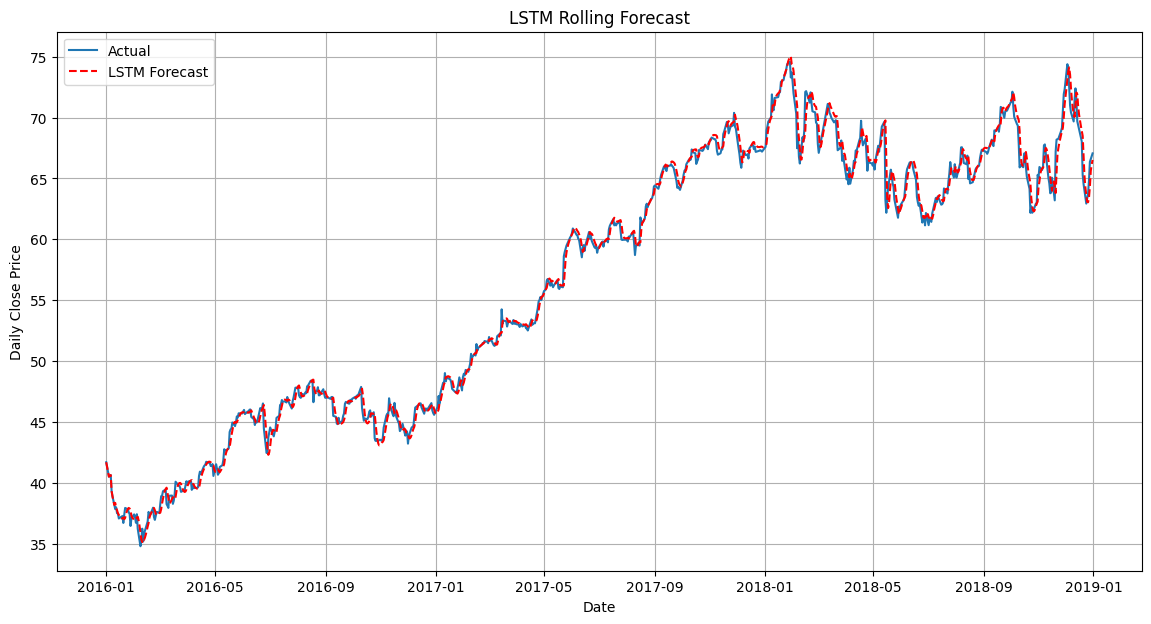

Processing aapl...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0178 - val_loss: 6.9820e-04
Epoch 2/20
144/144 [==============================] - 0s 3ms/step - loss: 5.5900e-05 - val_loss: 4.6848e-04
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 5.7718e-05 - val_loss: 4.2728e-04
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 5.4602e-05 - val_loss: 4.3130e-04
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 5.4951e-05 - val_loss: 3.6356e-04
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 5.2050e-05 - val_loss: 3.0811e-04
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 5.3394e-05 - val_loss: 5.7001e-04
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 5.2853e-05 - val_loss: 3.6194e-04
Epoch 9/20
144/144 [==============================] - 0s 2ms/step - loss: 5.1651e-05 - val_loss: 3.3762e-04
Epoch 10/20
1

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\aapl\predictions.csv.


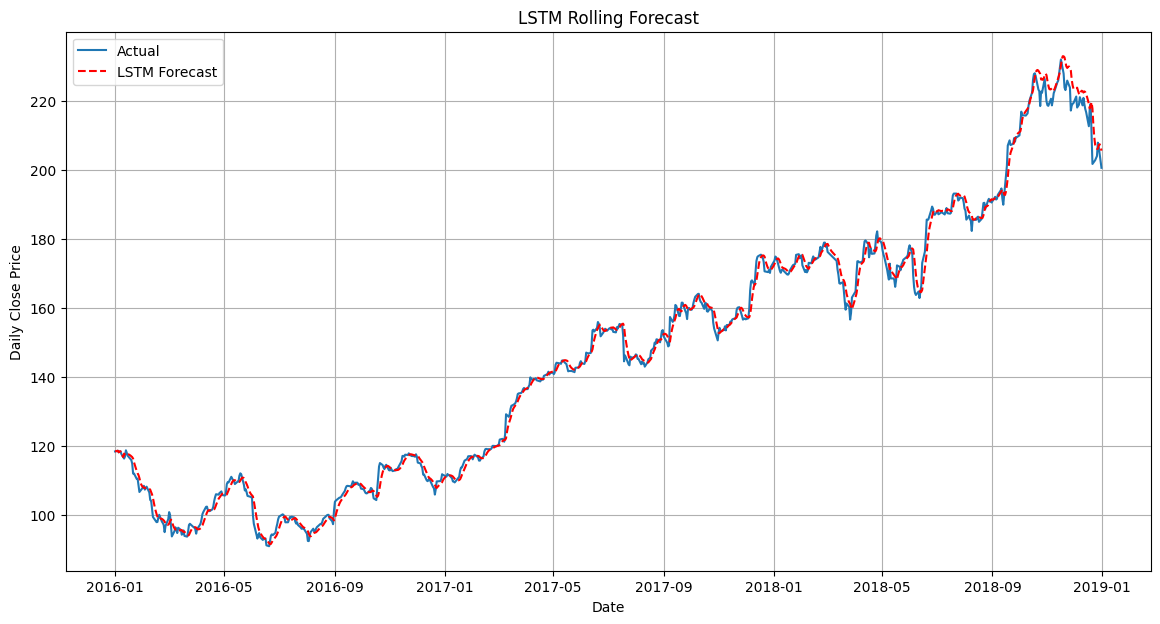

Processing abc...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0076 - val_loss: 0.0049
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 3.2292e-05 - val_loss: 0.0051
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 3.3301e-05 - val_loss: 0.0040
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 3.1937e-05 - val_loss: 0.0040
Epoch 5/20
144/144 [==============================] - 0s 3ms/step - loss: 3.2118e-05 - val_loss: 0.0043
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 2.9756e-05 - val_loss: 0.0032
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 3.0002e-05 - val_loss: 0.0041
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 3.1189e-05 - val_loss: 0.0032
Epoch 9/20
144/144 [==============================] - 0s 2ms/step - loss: 3.0762e-05 - val_loss: 0.0032
Epoch 10/20
144/144 [=============================

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\abc\predictions.csv.


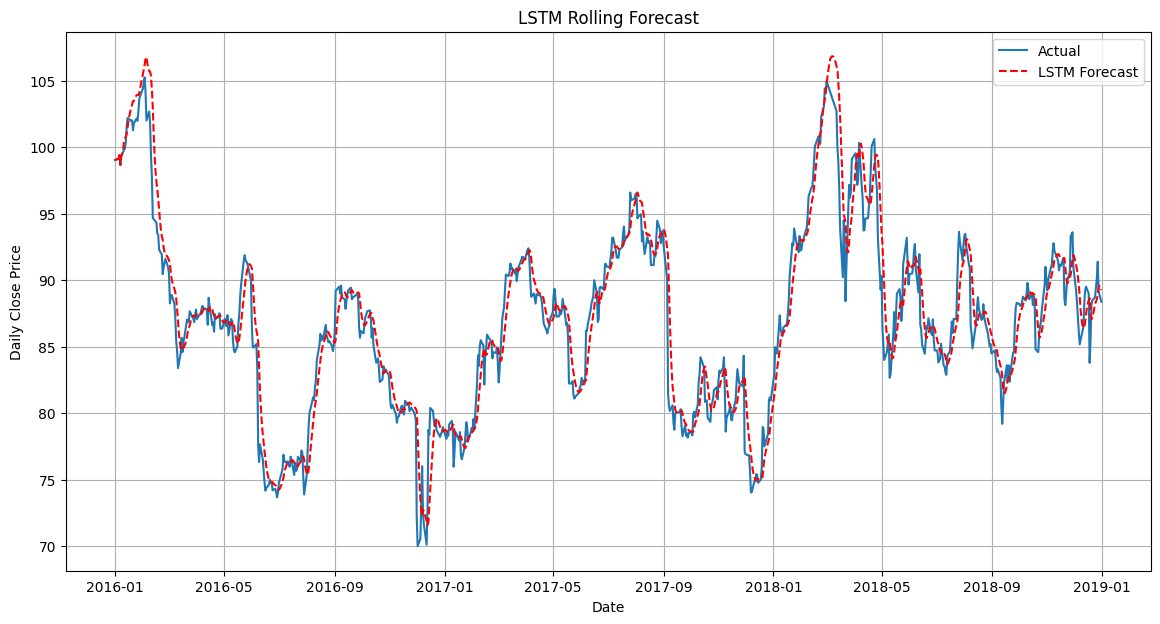

Processing abt...
Epoch 1/20
144/144 [==============================] - 3s 4ms/step - loss: 0.0117 - val_loss: 0.0096
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 2.1913e-04 - val_loss: 0.0046
Epoch 3/20
144/144 [==============================] - 0s 3ms/step - loss: 1.6736e-04 - val_loss: 0.0012
Epoch 4/20
144/144 [==============================] - 0s 3ms/step - loss: 1.6233e-04 - val_loss: 0.0014
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 1.5910e-04 - val_loss: 0.0013
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 1.5922e-04 - val_loss: 6.2426e-04
Epoch 7/20
144/144 [==============================] - 0s 3ms/step - loss: 1.4773e-04 - val_loss: 6.4102e-04
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 1.4007e-04 - val_loss: 7.0838e-04
Epoch 9/20
144/144 [==============================] - 0s 2ms/step - loss: 1.3440e-04 - val_loss: 5.0555e-04
Epoch 10/20
144/144 [=============

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\abt\predictions.csv.


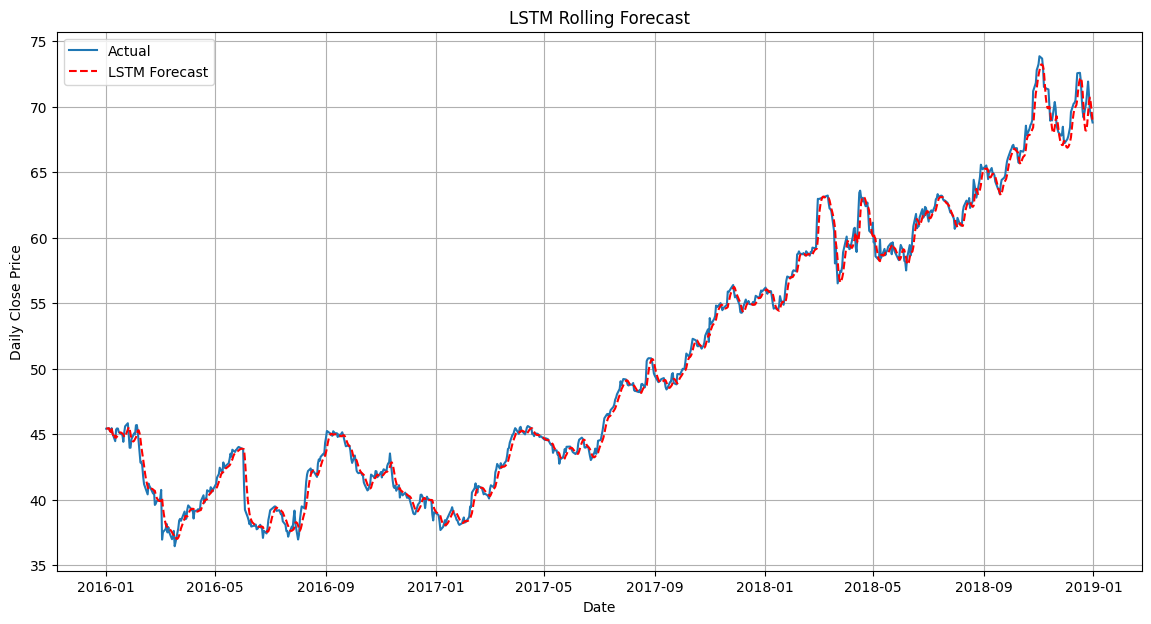

Processing acn...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0143 - val_loss: 0.0041
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 1.2112e-04 - val_loss: 0.0016
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 1.0929e-04 - val_loss: 0.0011
Epoch 4/20
144/144 [==============================] - 0s 3ms/step - loss: 1.0693e-04 - val_loss: 7.6604e-04
Epoch 5/20
144/144 [==============================] - 0s 3ms/step - loss: 1.0618e-04 - val_loss: 5.3046e-04
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 1.0460e-04 - val_loss: 5.1916e-04
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 1.0141e-04 - val_loss: 6.8703e-04
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 9.5905e-05 - val_loss: 3.7828e-04
Epoch 9/20
144/144 [==============================] - 0s 3ms/step - loss: 9.4976e-05 - val_loss: 4.1727e-04
Epoch 10/20
144/144 [=====

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\acn\predictions.csv.


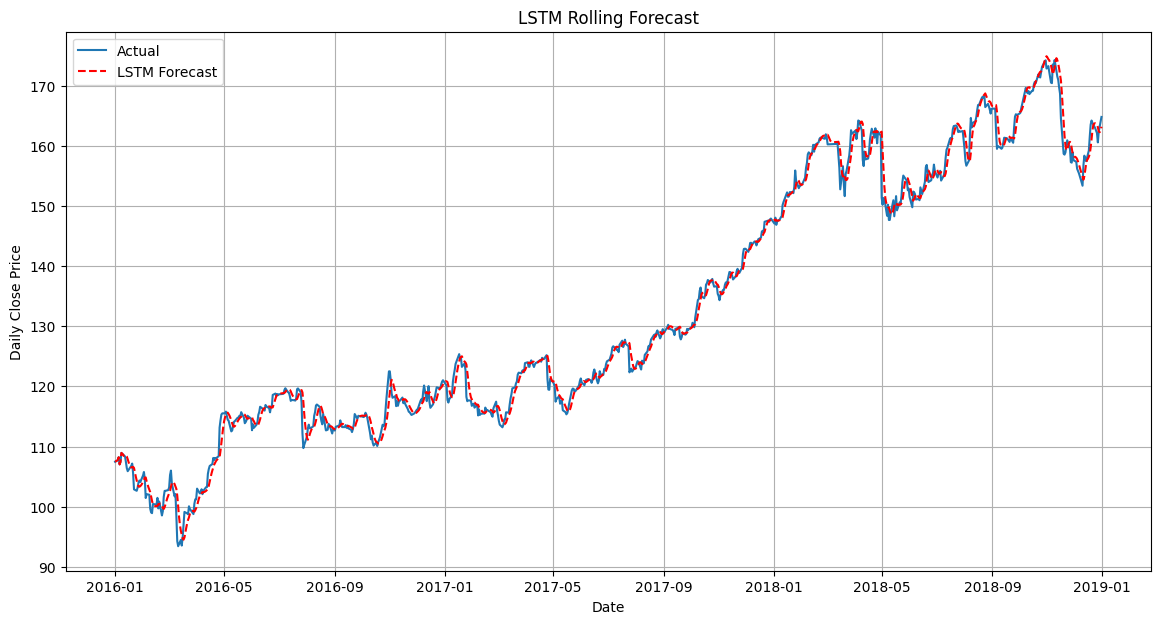

Processing adbe...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 6.8977e-04
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 1.1282e-04 - val_loss: 6.7692e-04
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 1.0868e-04 - val_loss: 5.3206e-04
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 1.1014e-04 - val_loss: 4.2849e-04
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 1.0627e-04 - val_loss: 3.2763e-04
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 1.0371e-04 - val_loss: 3.6354e-04
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 1.0199e-04 - val_loss: 3.4509e-04
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 9.0985e-05 - val_loss: 4.3992e-04
Epoch 9/20
144/144 [==============================] - 0s 3ms/step - loss: 8.9594e-05 - val_loss: 4.4855e-04
Epoch 10/20
1

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\adbe\predictions.csv.


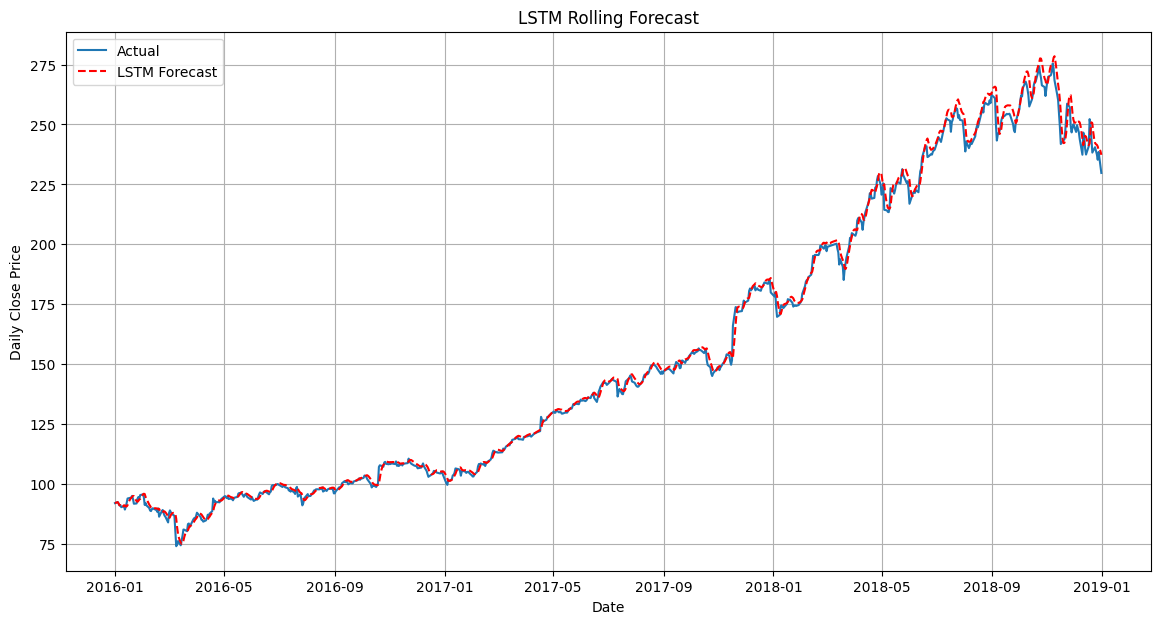

Processing adi...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0179 - val_loss: 0.0017
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 3.3878e-04 - val_loss: 8.1388e-04
Epoch 3/20
144/144 [==============================] - 0s 3ms/step - loss: 3.2446e-04 - val_loss: 0.0018
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 3.1569e-04 - val_loss: 6.5090e-04
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 2.9915e-04 - val_loss: 6.5805e-04
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 2.7901e-04 - val_loss: 8.0876e-04
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 2.7450e-04 - val_loss: 7.3583e-04
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 2.6370e-04 - val_loss: 8.1408e-04
Epoch 9/20
144/144 [==============================] - 0s 3ms/step - loss: 2.4930e-04 - val_loss: 5.3942e-04
Epoch 10/20
144/144 [=

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\adi\predictions.csv.


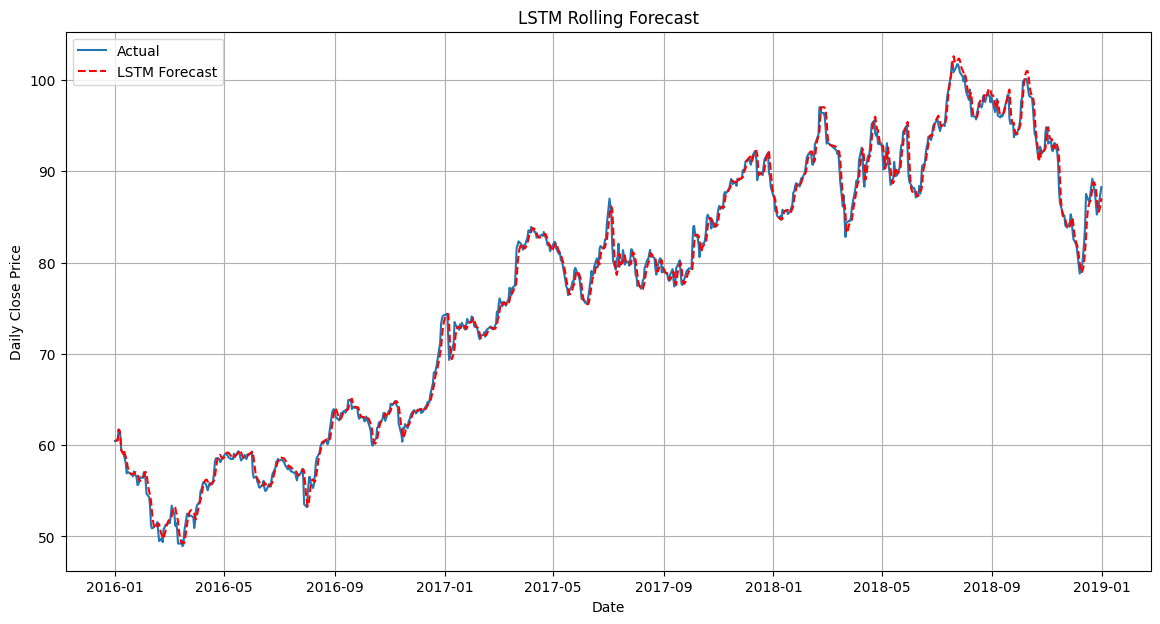

Processing adm...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0457 - val_loss: 0.0041
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 3.8450e-04 - val_loss: 0.0014
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 3.4747e-04 - val_loss: 0.0017
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 3.3493e-04 - val_loss: 0.0010
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 3.0901e-04 - val_loss: 8.0234e-04
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 2.9460e-04 - val_loss: 9.1122e-04
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 2.5945e-04 - val_loss: 4.4728e-04
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 2.4273e-04 - val_loss: 3.3326e-04
Epoch 9/20
144/144 [==============================] - 0s 2ms/step - loss: 2.1643e-04 - val_loss: 5.3110e-04
Epoch 10/20
144/144 [=========

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 2ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\adm\predictions.csv.


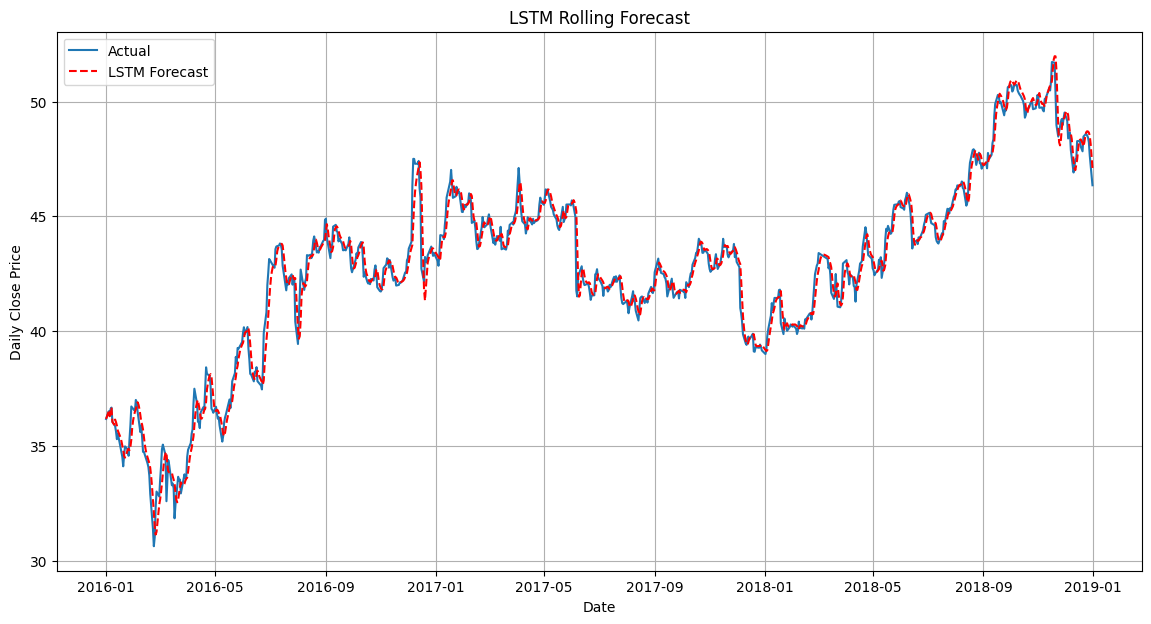

Processing adp...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0166 - val_loss: 0.0106
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 1.2697e-04 - val_loss: 0.0064
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 1.1900e-04 - val_loss: 0.0043
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 1.0966e-04 - val_loss: 0.0045
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 1.1263e-04 - val_loss: 0.0024
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 1.0560e-04 - val_loss: 0.0018
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 1.0070e-04 - val_loss: 0.0017
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 1.0462e-04 - val_loss: 0.0014
Epoch 9/20
144/144 [==============================] - 0s 2ms/step - loss: 9.2577e-05 - val_loss: 9.3860e-04
Epoch 10/20
144/144 [=========================

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 3ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\adp\predictions.csv.


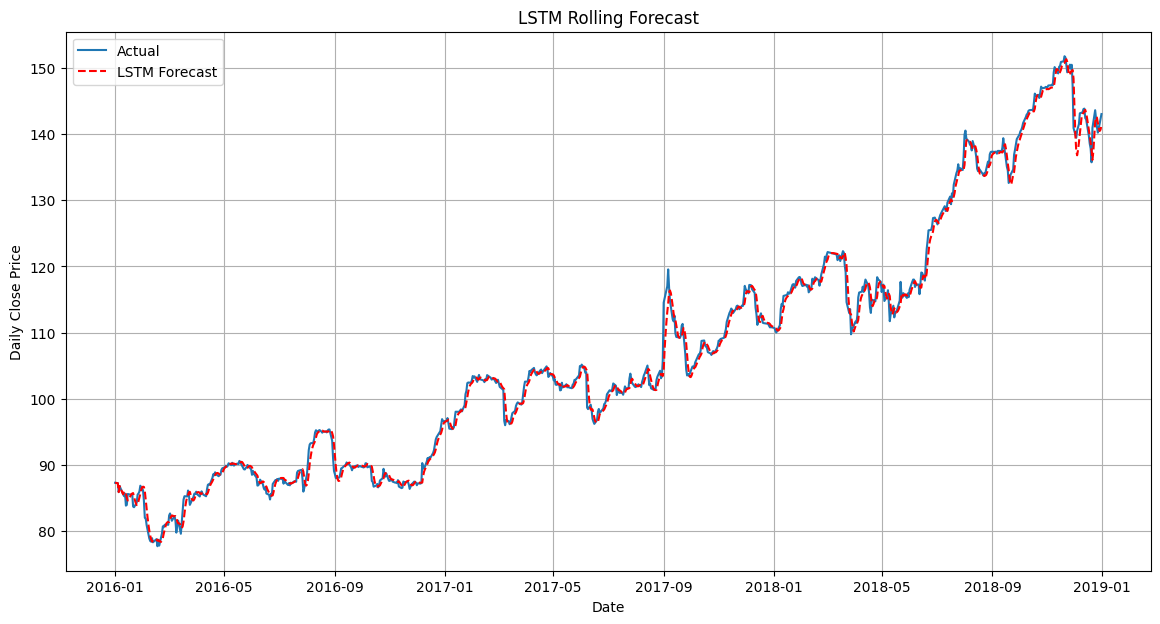

Processing ads...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0129 - val_loss: 0.0031
Epoch 2/20
144/144 [==============================] - 0s 3ms/step - loss: 1.2483e-04 - val_loss: 7.2269e-04
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 9.6104e-05 - val_loss: 6.3718e-04
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 9.6296e-05 - val_loss: 6.0946e-04
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 8.9029e-05 - val_loss: 7.9079e-04
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 8.8978e-05 - val_loss: 7.5365e-04
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 8.5225e-05 - val_loss: 7.2277e-04
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 8.3590e-05 - val_loss: 5.2156e-04
Epoch 9/20
144/144 [==============================] - 0s 2ms/step - loss: 8.2786e-05 - val_loss: 4.9109e-04
Epoch 10/20
144/14

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\ads\predictions.csv.


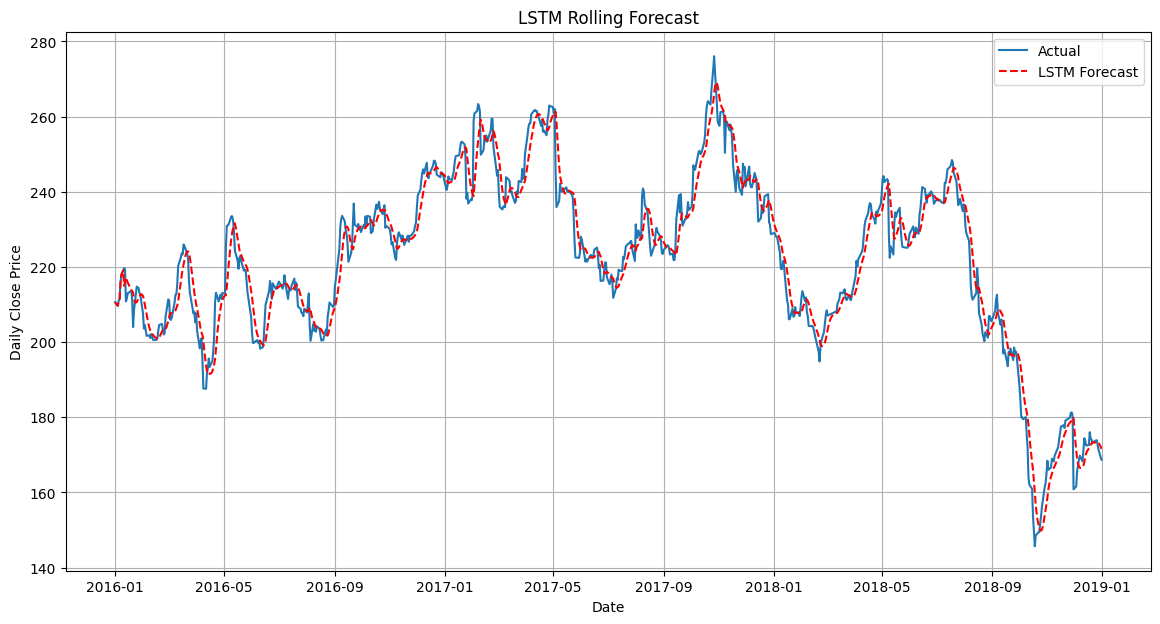

Processing adsk...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0346 - val_loss: 0.0027
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 2.3801e-04 - val_loss: 8.4564e-04
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 2.2293e-04 - val_loss: 4.2126e-04
Epoch 4/20
144/144 [==============================] - 0s 3ms/step - loss: 2.1169e-04 - val_loss: 3.6970e-04
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 2.0922e-04 - val_loss: 3.6399e-04
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 1.9759e-04 - val_loss: 3.4777e-04
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 1.8541e-04 - val_loss: 3.5671e-04
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 2.0600e-04 - val_loss: 4.6120e-04
Epoch 9/20
144/144 [==============================] - 0s 2ms/step - loss: 1.7120e-04 - val_loss: 2.9721e-04
Epoch 10/20
144/1

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 2ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\adsk\predictions.csv.


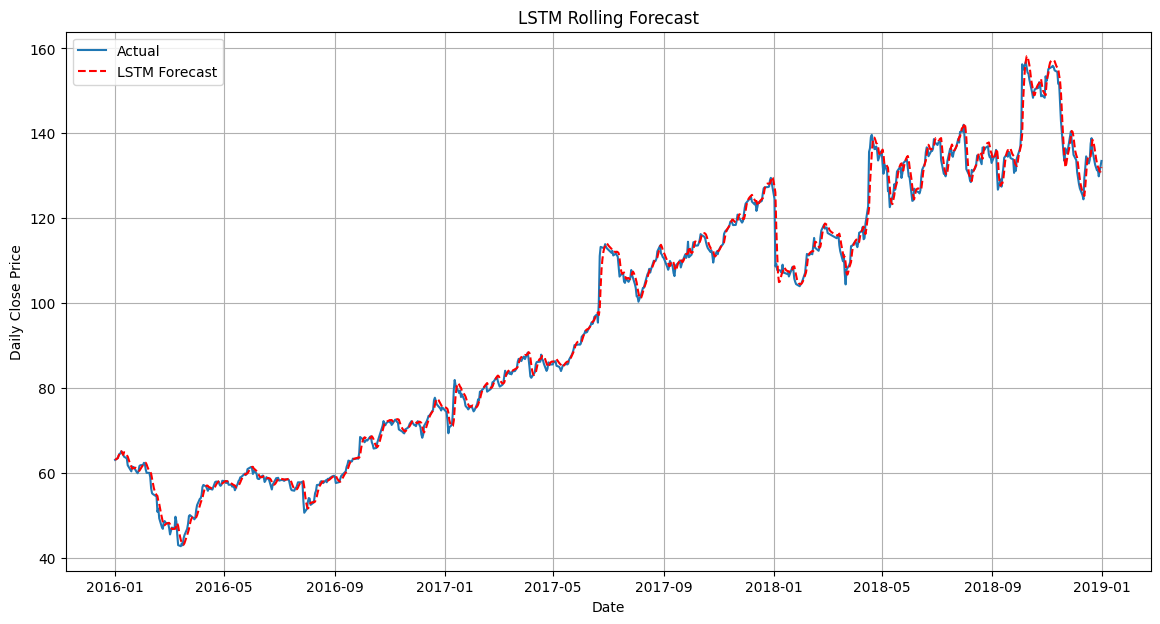

Processing aee...
Epoch 1/20
144/144 [==============================] - 3s 4ms/step - loss: 0.0445 - val_loss: 6.1020e-04
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 3.8595e-04 - val_loss: 3.4542e-04
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 3.3433e-04 - val_loss: 3.6372e-04
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 3.0903e-04 - val_loss: 3.3790e-04
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 3.0031e-04 - val_loss: 2.7448e-04
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 2.7312e-04 - val_loss: 3.3676e-04
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 2.5876e-04 - val_loss: 2.5984e-04
Epoch 8/20
144/144 [==============================] - 0s 3ms/step - loss: 2.4333e-04 - val_loss: 2.1843e-04
Epoch 9/20
144/144 [==============================] - 0s 3ms/step - loss: 2.2104e-04 - val_loss: 1.9851e-04
Epoch 10/20
14

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\aee\predictions.csv.


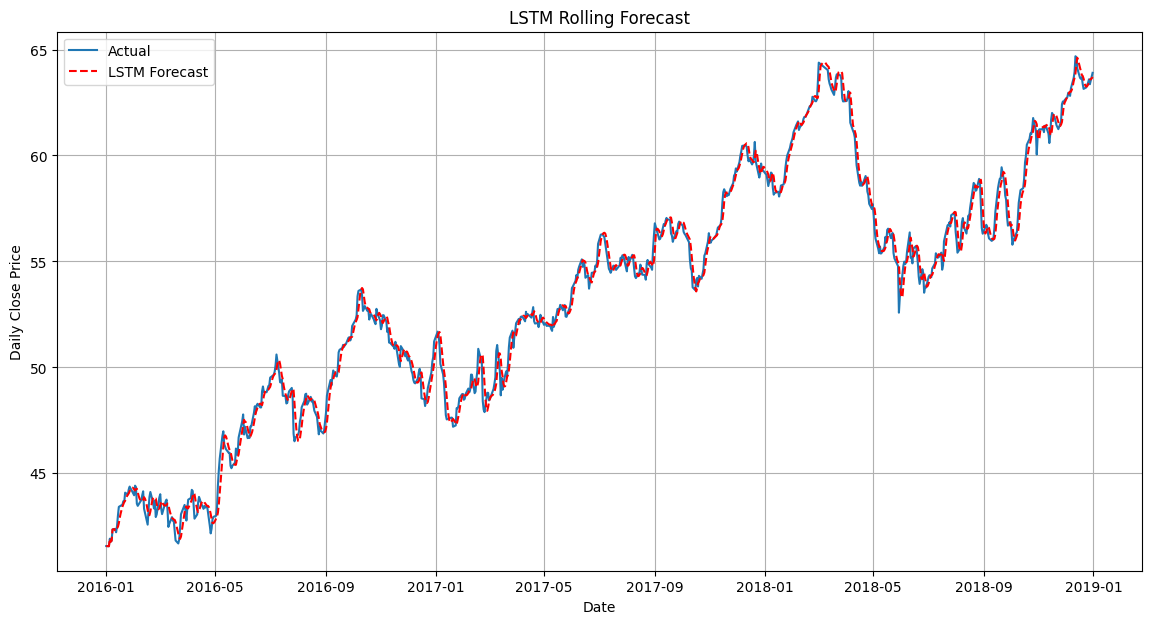

Processing aep...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0375 - val_loss: 0.0048
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 3.1625e-04 - val_loss: 0.0014
Epoch 3/20
144/144 [==============================] - 0s 3ms/step - loss: 2.8323e-04 - val_loss: 0.0011
Epoch 4/20
144/144 [==============================] - 0s 3ms/step - loss: 2.7089e-04 - val_loss: 7.8907e-04
Epoch 5/20
144/144 [==============================] - 0s 3ms/step - loss: 2.5650e-04 - val_loss: 6.3662e-04
Epoch 6/20
144/144 [==============================] - 0s 3ms/step - loss: 2.4486e-04 - val_loss: 5.4673e-04
Epoch 7/20
144/144 [==============================] - 0s 3ms/step - loss: 2.3064e-04 - val_loss: 7.8266e-04
Epoch 8/20
144/144 [==============================] - 0s 3ms/step - loss: 2.1470e-04 - val_loss: 4.6338e-04
Epoch 9/20
144/144 [==============================] - 0s 3ms/step - loss: 1.9639e-04 - val_loss: 5.7727e-04
Epoch 10/20
144/144 [=====

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\aep\predictions.csv.


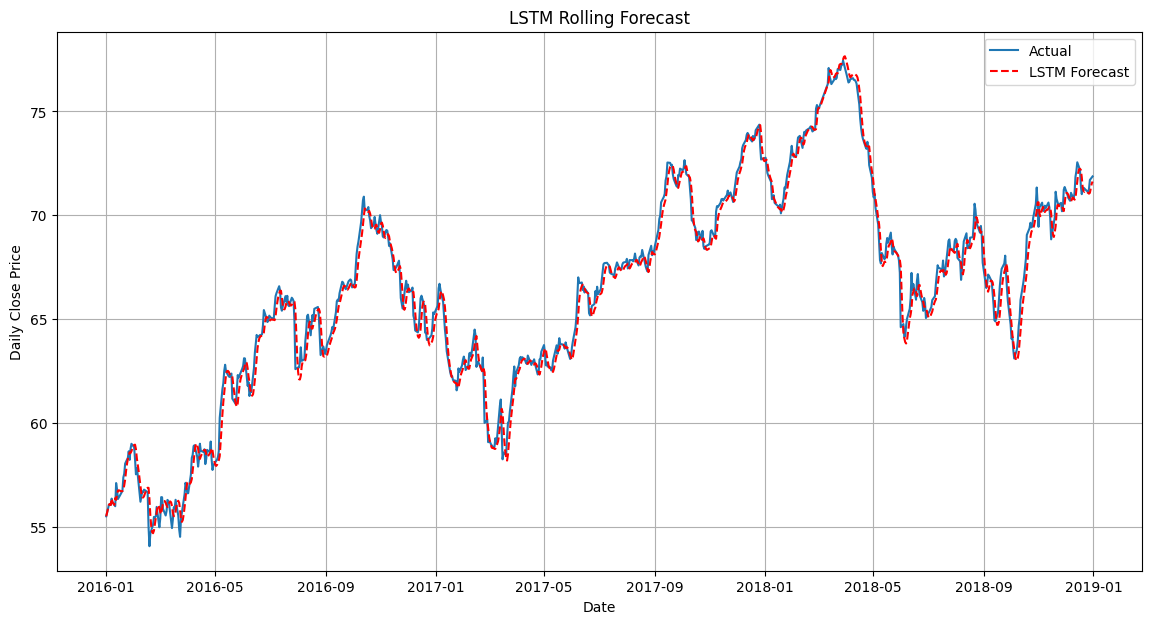

Processing aes...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0529 - val_loss: 1.9872e-04
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 4.0257e-04 - val_loss: 1.5730e-04
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 3.4916e-04 - val_loss: 1.4071e-04
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 3.2159e-04 - val_loss: 1.1175e-04
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 3.1160e-04 - val_loss: 1.1126e-04
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 2.8303e-04 - val_loss: 1.1170e-04
Epoch 7/20
144/144 [==============================] - 0s 3ms/step - loss: 2.7390e-04 - val_loss: 9.3887e-05
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 2.4496e-04 - val_loss: 8.1473e-05
Epoch 9/20
144/144 [==============================] - 0s 2ms/step - loss: 2.1977e-04 - val_loss: 1.5962e-04
Epoch 10/20
14

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\aes\predictions.csv.


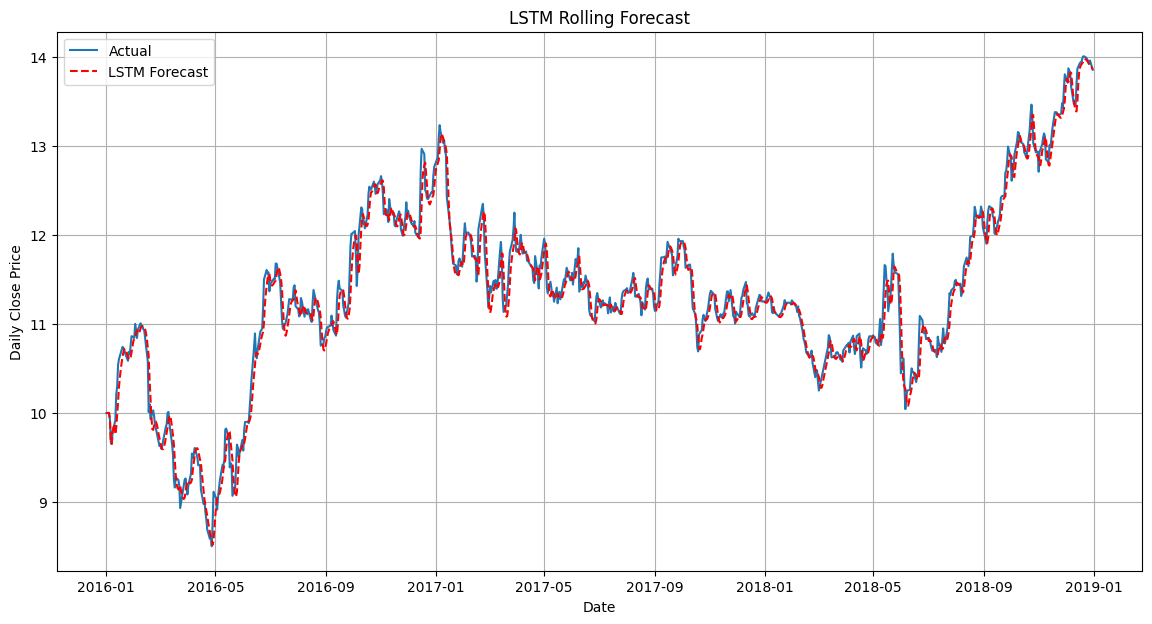

Processing afl...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0501 - val_loss: 3.4397e-04
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 6.2528e-04 - val_loss: 2.8582e-04
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 5.1584e-04 - val_loss: 2.6065e-04
Epoch 4/20
144/144 [==============================] - 0s 3ms/step - loss: 4.8655e-04 - val_loss: 2.7781e-04
Epoch 5/20
144/144 [==============================] - 0s 3ms/step - loss: 4.5687e-04 - val_loss: 2.1807e-04
Epoch 6/20
144/144 [==============================] - 0s 3ms/step - loss: 4.4318e-04 - val_loss: 4.7258e-04
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 4.2706e-04 - val_loss: 2.0339e-04
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 3.9730e-04 - val_loss: 1.8569e-04
Epoch 9/20
144/144 [==============================] - 0s 2ms/step - loss: 3.6676e-04 - val_loss: 2.9125e-04
Epoch 10/20
14

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\afl\predictions.csv.


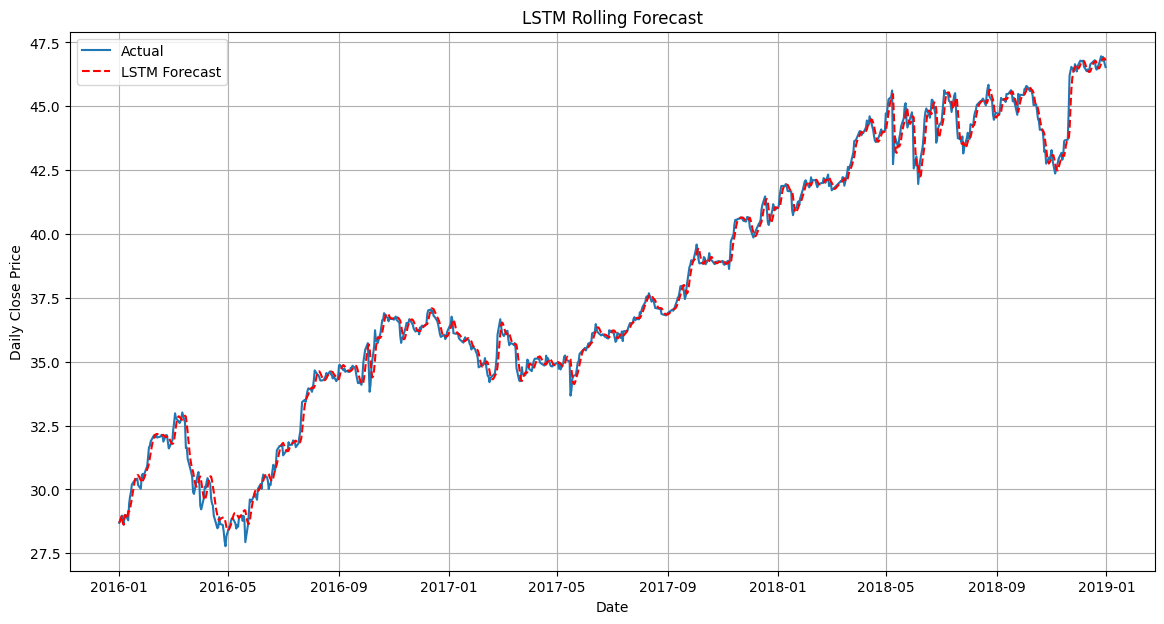

Processing agn...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0041 - val_loss: 3.4378e-04
Epoch 2/20
144/144 [==============================] - 0s 3ms/step - loss: 2.6567e-05 - val_loss: 3.9024e-04
Epoch 3/20
144/144 [==============================] - 1s 5ms/step - loss: 2.5848e-05 - val_loss: 3.2579e-04
Epoch 4/20
144/144 [==============================] - 0s 3ms/step - loss: 2.5884e-05 - val_loss: 4.2659e-04
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 2.5831e-05 - val_loss: 4.0001e-04
Epoch 6/20
144/144 [==============================] - 0s 3ms/step - loss: 2.4855e-05 - val_loss: 3.1560e-04
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 2.7037e-05 - val_loss: 3.0515e-04
Epoch 8/20
144/144 [==============================] - 0s 3ms/step - loss: 2.8803e-05 - val_loss: 3.8694e-04
Epoch 9/20
144/144 [==============================] - 1s 4ms/step - loss: 2.4951e-05 - val_loss: 3.4147e-04
Epoch 10/20
14

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\agn\predictions.csv.


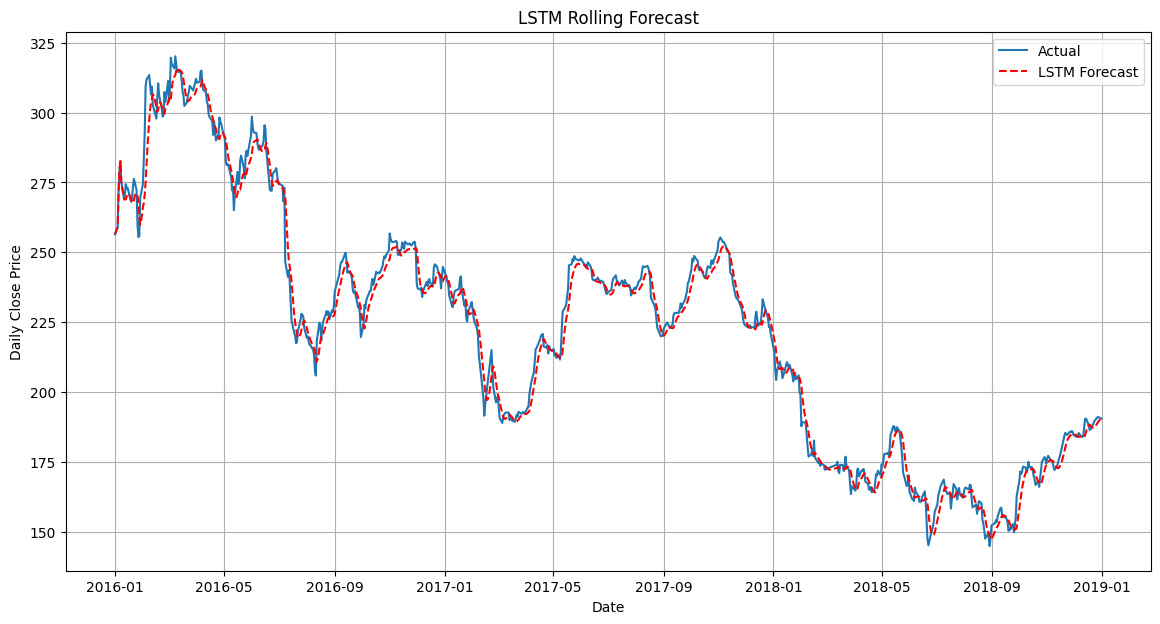

Processing aig...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0451 - val_loss: 3.1615e-06
Epoch 2/20
144/144 [==============================] - 0s 3ms/step - loss: 3.1155e-04 - val_loss: 2.5723e-06
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 2.4617e-04 - val_loss: 9.9210e-07
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 2.2894e-04 - val_loss: 3.7196e-06
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 2.1762e-04 - val_loss: 7.3290e-07
Epoch 6/20
144/144 [==============================] - 1s 5ms/step - loss: 2.0895e-04 - val_loss: 6.0200e-07
Epoch 7/20
144/144 [==============================] - 1s 4ms/step - loss: 2.0481e-04 - val_loss: 1.3561e-05
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 2.0419e-04 - val_loss: 3.4938e-06
Epoch 9/20
144/144 [==============================] - 1s 4ms/step - loss: 1.9700e-04 - val_loss: 6.7019e-05
Epoch 10/20
14

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 2ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\aig\predictions.csv.


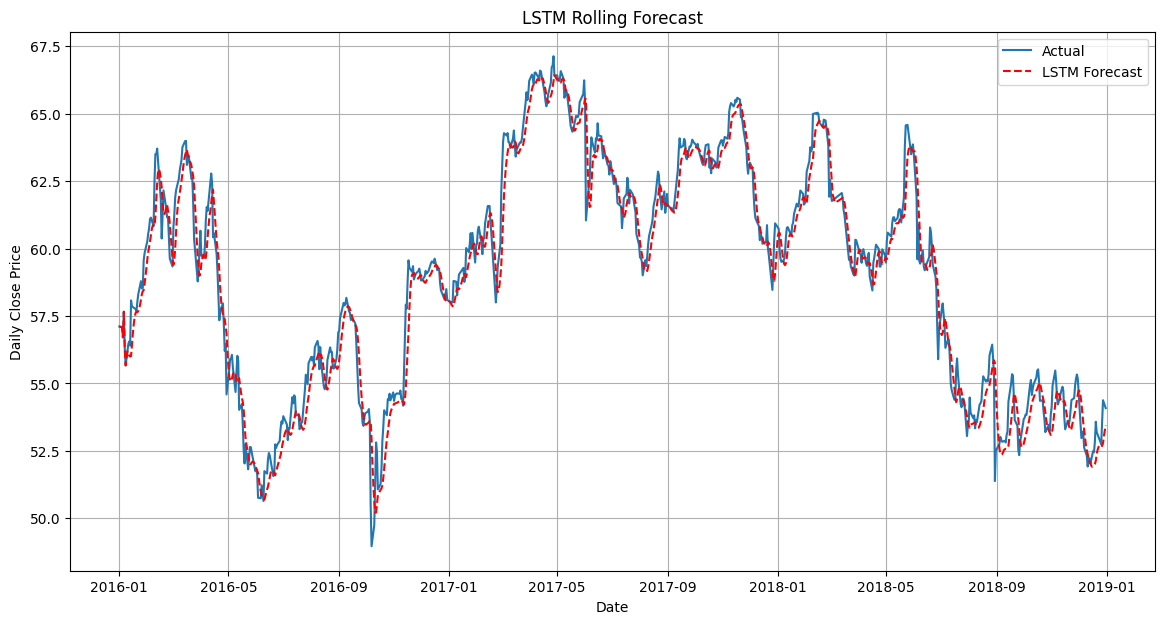

Processing aiv...
Epoch 1/20
144/144 [==============================] - 2s 6ms/step - loss: 0.0291 - val_loss: 1.5708e-04
Epoch 2/20
144/144 [==============================] - 1s 4ms/step - loss: 2.6485e-04 - val_loss: 1.4211e-04
Epoch 3/20
144/144 [==============================] - 0s 3ms/step - loss: 2.4381e-04 - val_loss: 1.4141e-04
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 2.3448e-04 - val_loss: 1.3244e-04
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 2.2419e-04 - val_loss: 2.0538e-04
Epoch 6/20
144/144 [==============================] - 1s 4ms/step - loss: 2.1998e-04 - val_loss: 1.0560e-04
Epoch 7/20
144/144 [==============================] - 0s 3ms/step - loss: 2.0902e-04 - val_loss: 2.0359e-04
Epoch 8/20
144/144 [==============================] - 1s 4ms/step - loss: 1.9206e-04 - val_loss: 9.9290e-05
Epoch 9/20
144/144 [==============================] - 1s 4ms/step - loss: 1.8589e-04 - val_loss: 2.0174e-04
Epoch 10/20
14

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\aiv\predictions.csv.


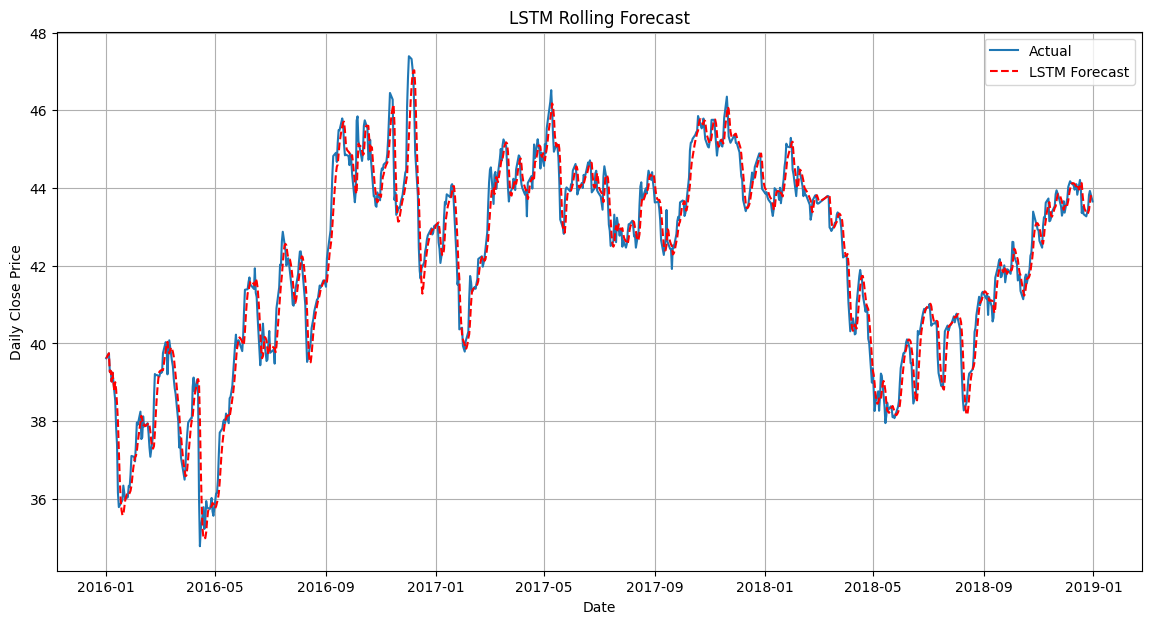

Processing amzn...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0090 - val_loss: 0.0018
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 8.3868e-05 - val_loss: 0.0011
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 7.6746e-05 - val_loss: 8.5646e-04
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 7.6931e-05 - val_loss: 6.7315e-04
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 7.4006e-05 - val_loss: 6.2131e-04
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 7.7657e-05 - val_loss: 6.8206e-04
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 7.2064e-05 - val_loss: 5.5640e-04
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 7.2073e-05 - val_loss: 5.2678e-04
Epoch 9/20
144/144 [==============================] - 0s 2ms/step - loss: 6.9357e-05 - val_loss: 4.8325e-04
Epoch 10/20
144/144 [

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\amzn\predictions.csv.


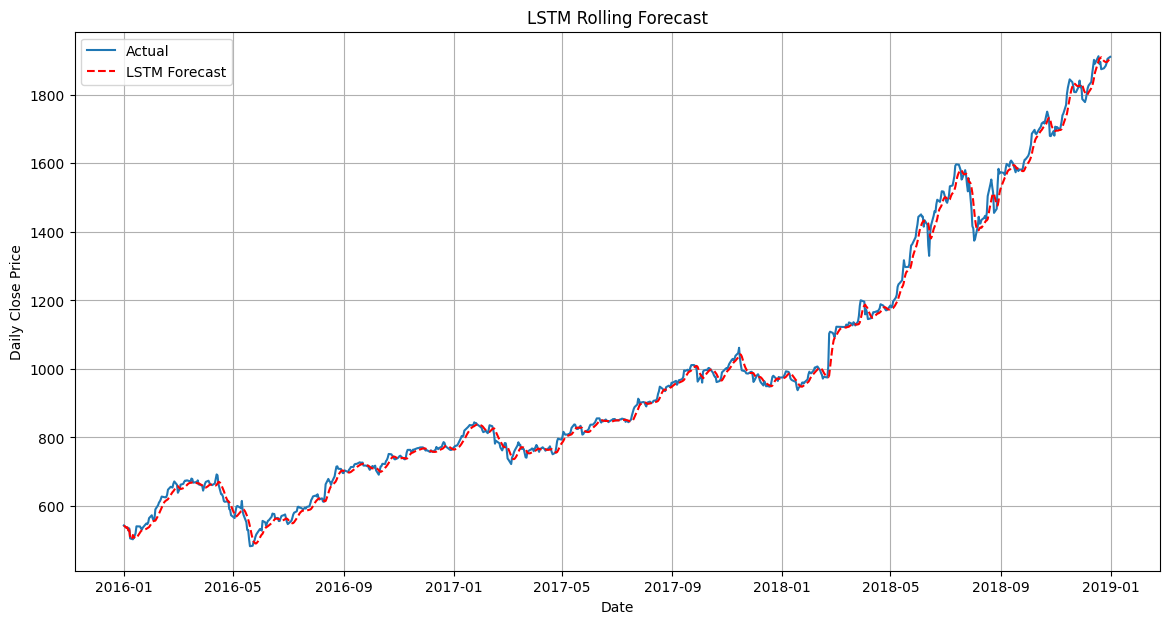

Processing jnj...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0204 - val_loss: 0.0028
Epoch 2/20
144/144 [==============================] - 0s 3ms/step - loss: 1.9185e-04 - val_loss: 0.0018
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 1.6994e-04 - val_loss: 0.0023
Epoch 4/20
144/144 [==============================] - 0s 3ms/step - loss: 1.6395e-04 - val_loss: 0.0013
Epoch 5/20
144/144 [==============================] - 1s 4ms/step - loss: 1.4526e-04 - val_loss: 6.9055e-04
Epoch 6/20
144/144 [==============================] - 0s 3ms/step - loss: 1.3468e-04 - val_loss: 6.1424e-04
Epoch 7/20
144/144 [==============================] - 1s 6ms/step - loss: 1.2179e-04 - val_loss: 6.2581e-04
Epoch 8/20
144/144 [==============================] - 0s 3ms/step - loss: 1.1201e-04 - val_loss: 3.2861e-04
Epoch 9/20
144/144 [==============================] - 1s 4ms/step - loss: 1.1158e-04 - val_loss: 2.0678e-04
Epoch 10/20
144/144 [=========

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\jnj\predictions.csv.


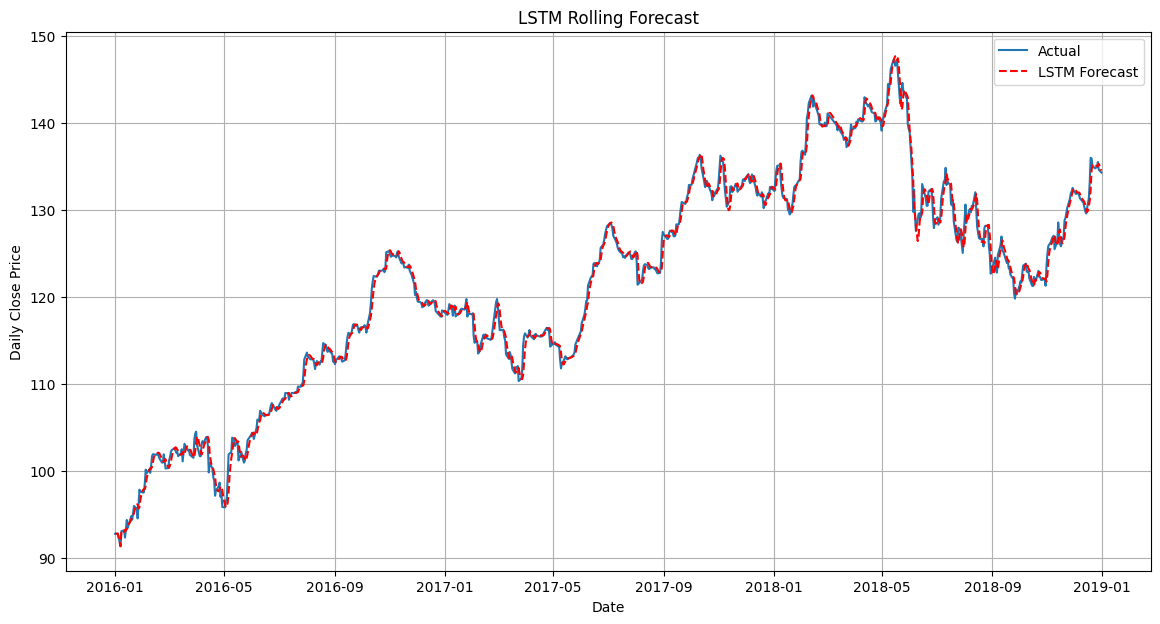

Processing jpm...
Epoch 1/20
144/144 [==============================] - 3s 4ms/step - loss: 0.0264 - val_loss: 0.0034
Epoch 2/20
144/144 [==============================] - 0s 3ms/step - loss: 5.9876e-04 - val_loss: 0.0020
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 4.7316e-04 - val_loss: 7.9821e-04
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 4.2908e-04 - val_loss: 8.7638e-04
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 3.9452e-04 - val_loss: 5.7534e-04
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 3.3550e-04 - val_loss: 2.9676e-04
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 3.0737e-04 - val_loss: 5.9373e-04
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 2.6064e-04 - val_loss: 2.4320e-04
Epoch 9/20
144/144 [==============================] - 0s 2ms/step - loss: 2.5551e-04 - val_loss: 3.6921e-04
Epoch 10/20
144/144 [=

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\jpm\predictions.csv.


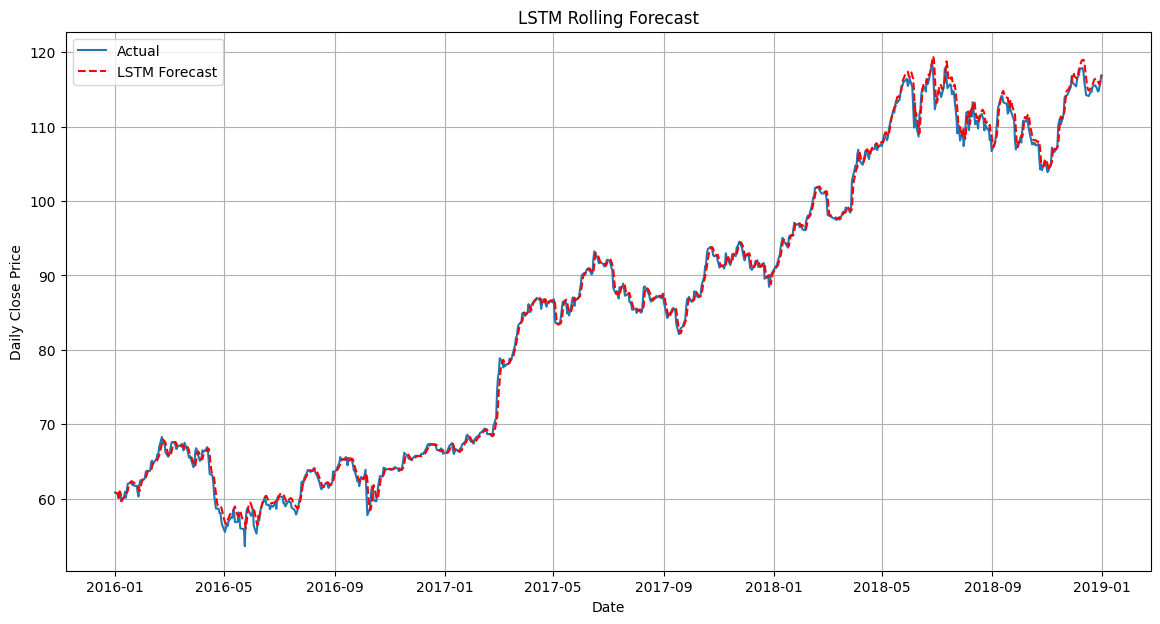

Processing ko...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0095 - val_loss: 0.0015
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 2.8148e-04 - val_loss: 9.3187e-04
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 2.5535e-04 - val_loss: 7.3446e-04
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 2.4345e-04 - val_loss: 5.4771e-04
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 2.4981e-04 - val_loss: 5.2561e-04
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 2.3745e-04 - val_loss: 5.2385e-04
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 2.2760e-04 - val_loss: 4.0172e-04
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 2.2530e-04 - val_loss: 3.6748e-04
Epoch 9/20
144/144 [==============================] - 0s 2ms/step - loss: 2.0370e-04 - val_loss: 4.5822e-04
Epoch 10/20
144/144

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\ko\predictions.csv.


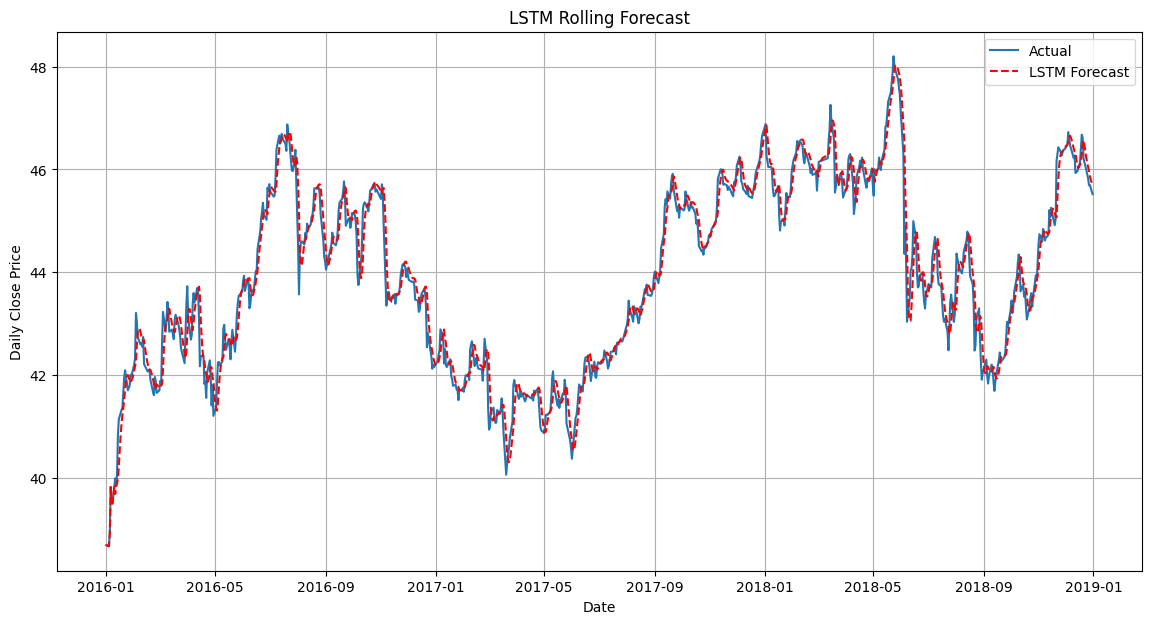

Processing mmm...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0080 - val_loss: 0.0039
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 1.2896e-04 - val_loss: 0.0028
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 1.2274e-04 - val_loss: 0.0022
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 1.1897e-04 - val_loss: 0.0017
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 1.1578e-04 - val_loss: 0.0014
Epoch 6/20
144/144 [==============================] - 0s 3ms/step - loss: 1.1148e-04 - val_loss: 5.5099e-04
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 1.1446e-04 - val_loss: 7.5905e-04
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 1.0389e-04 - val_loss: 0.0014
Epoch 9/20
144/144 [==============================] - 0s 2ms/step - loss: 1.0440e-04 - val_loss: 2.5553e-04
Epoch 10/20
144/144 [=================

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\mmm\predictions.csv.


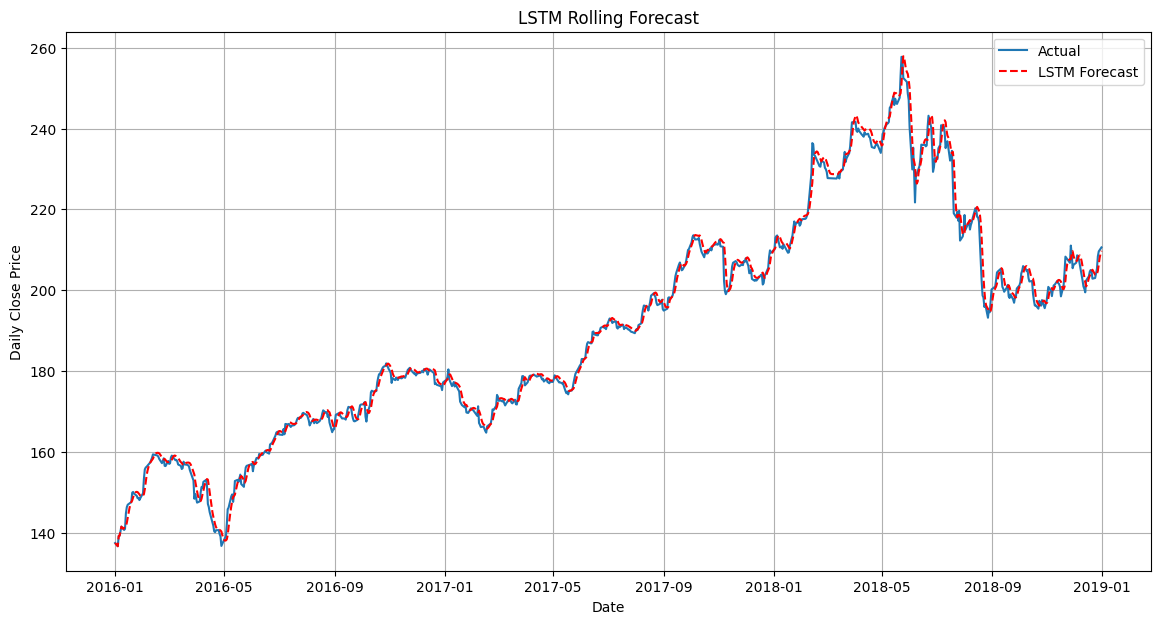

Processing msft...
Epoch 1/20
144/144 [==============================] - 2s 4ms/step - loss: 0.0105 - val_loss: 0.0082
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 3.1361e-04 - val_loss: 0.0020
Epoch 3/20
144/144 [==============================] - 0s 3ms/step - loss: 2.7967e-04 - val_loss: 0.0025
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 2.6189e-04 - val_loss: 0.0022
Epoch 5/20
144/144 [==============================] - 0s 2ms/step - loss: 2.4624e-04 - val_loss: 0.0020
Epoch 6/20
144/144 [==============================] - 0s 2ms/step - loss: 2.3789e-04 - val_loss: 0.0015
Epoch 7/20
144/144 [==============================] - 0s 2ms/step - loss: 2.2248e-04 - val_loss: 8.4450e-04
Epoch 8/20
144/144 [==============================] - 0s 2ms/step - loss: 2.1108e-04 - val_loss: 0.0017
Epoch 9/20
144/144 [==============================] - 0s 2ms/step - loss: 1.9921e-04 - val_loss: 6.2843e-04
Epoch 10/20
144/144 [====================

d:\ProgramFiles_Storage\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 1ms/step
Predictions saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\msft\predictions.csv.


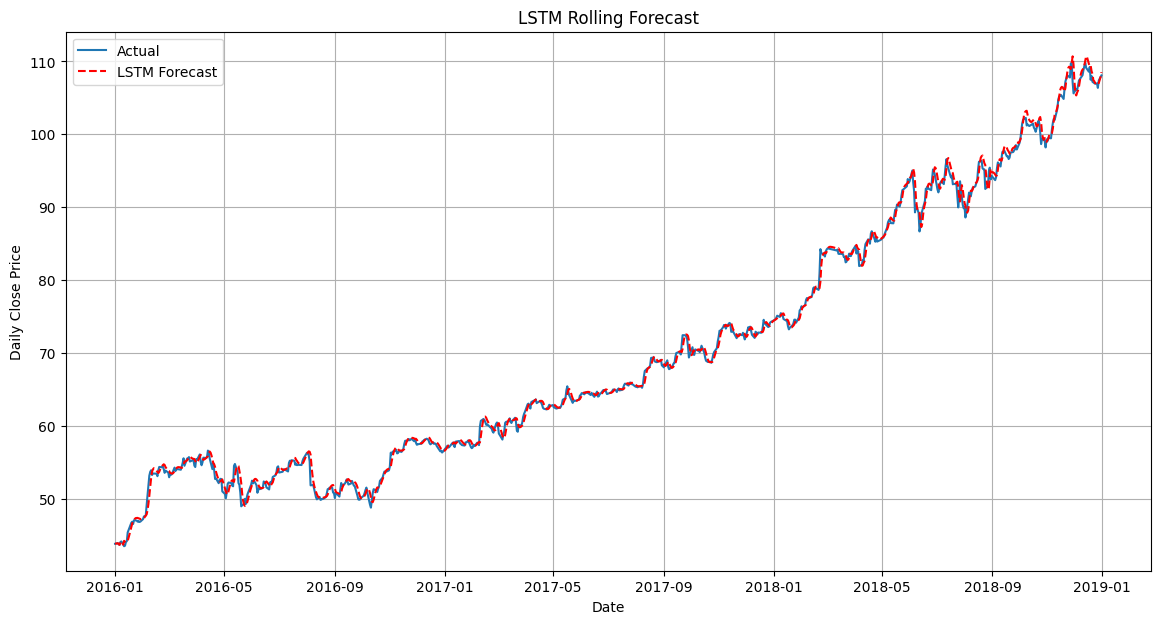

In [66]:
def process_stocks(project_dir):
    datasets, stock_names = get_csvs_from_dir(project_dir)
    for file_path, stock_name in zip(datasets, stock_names):
        print(f"Processing {stock_name}...")
        results_dir = os.path.join(project_dir, 'agents', 'trained_models', stock_name)
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
        train_and_forecast(file_path, results_dir)

if __name__ == '__main__':
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
    process_stocks(project_dir)